In [42]:
# Necessary imports

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bs4
import time
import matplotlib.pyplot as plt
from env import github_token, github_username

import acquire
from prepare import prep_data, remove_stopwords, split

import nltk
import unicodedata
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

### Acquire the data

In [2]:
# data = acquire.scrape_github_data()

#### Successfully acquired urls and turned into a df

In [3]:
# df = pd.DataFrame(data)

In [4]:
# Write df to csv file

# df.to_csv('repos.csv')

In [5]:
# convert back to a df and specify the index

data_df = pd.read_csv ('repos.csv', index_col=0)

In [6]:
# checking out the df

data_df.head()

,repo,language,readme_contents
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w..."
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...
3,nwjs/nw.js,JavaScript,## node-webkit is renamed NW.js\n\n[![Gitter](...
4,PKUanonym/REKCARC-TSC-UHT,HTML,# 清华大学计算机系课程攻略\n\n[![](https://img.shields.io/...


In [7]:
# Taking a closer look at the columns of my df

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 406
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             407 non-null    object
 1   language         337 non-null    object
 2   readme_contents  403 non-null    object
dtypes: object(3)
memory usage: 12.7+ KB


## Prepare

#### Checking out nulls in the 'language' column

In [8]:
# I see that I have 70 nulls values

data_df.language.value_counts(dropna=False)

JavaScript          83
NaN                 70
Java                36
C++                 30
Python              28
HTML                27
C                   24
C#                  17
TypeScript          14
Go                  11
Jupyter Notebook     8
Shell                8
Swift                6
CSS                  5
Kotlin               4
Objective-C          4
Ruby                 4
PowerShell           4
TeX                  3
Dart                 2
Scala                2
PHP                  2
CoffeeScript         2
Groovy               1
Rust                 1
PostScript           1
Ada                  1
Nunjucks             1
Handlebars           1
Assembly             1
Erlang               1
Nix                  1
MATLAB               1
Makefile             1
Objective-C++        1
Clojure              1
Name: language, dtype: int64

#### Made the decision to drop all of the 'language' nulls, taking my data from 407 observations to 337 observations

In [9]:
# dropping nulls

data_df = data_df.dropna()

In [10]:
# checking out the df shape

data_df.shape

(333, 3)

In [11]:
# dropping any languages that have less than 5 occurances

data_df = data_df.groupby('language').filter(lambda x : len(x)>10)

In [12]:
# confirming the new look of the 'language' column

data_df.language.value_counts(dropna=False)

JavaScript    82
Java          36
Python        28
C++           28
HTML          27
C             23
C#            17
TypeScript    14
Go            11
Name: language, dtype: int64

In [13]:
# checking out the df shape

data_df.shape

(266, 3)

In [14]:
df = prep_data(data_df, 'readme_contents').reset_index().drop(columns='index')
df.head()

,repo,language,readme_contents,clean_lemmatized
0,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movie application project building single page...
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel several guide kernel developer us...
2,nwjs/nw.js,JavaScript,## node-webkit is renamed NW.js\n\n[![Gitter](...,nodewebkit renamed nwjs gitterhttpsbadgesgitte...
3,PKUanonym/REKCARC-TSC-UHT,HTML,# 清华大学计算机系课程攻略\n\n[![](https://img.shields.io/...,httpsimgshieldsiogithubwatcherspkuanonymrekcar...
4,yeasy/docker_practice,Go,# Docker — 从入门到实践\n\n[![](https://img.shields....,docker httpsimgshieldsiogithubstarsyeasydocker...


#### After prepping my data, I have dropped from an initial 407 observatins to 266 observations

- I dropped my null values: 70 in 'language" and 4 in 'readme_contents'
- I dropped any language that had less than 10 occurances
- I used my prepare.py to clean, tokenize, and lemmatize the 'readme_contents' column

### Explore

In [15]:
# Create a dictionary to hold subsets by language.

lang_dict = {}

for lang in df.language:
    lang_dict[f'{lang}'] = df[df.language == lang]

In [16]:
lang_dict.keys()

dict_keys(['JavaScript', 'C', 'HTML', 'Go', 'TypeScript', 'C++', 'C#', 'Python', 'Java'])

In [17]:
# Create strings of cleaned and lemmatized words by language.

js_words = ' '.join(lang_dict['JavaScript'].clean_lemmatized)
c_words = ' '.join(lang_dict['C'].clean_lemmatized)
html_words = ' '.join(lang_dict['HTML'].clean_lemmatized)
go_words = ' '.join(lang_dict['Go'].clean_lemmatized)
typescript_words = ' '.join(lang_dict['TypeScript'].clean_lemmatized)
c_plus_words = ' '.join(lang_dict['C++'].clean_lemmatized)
c_sharp_words = ' '.join(lang_dict['C#'].clean_lemmatized)
python_words = ' '.join(lang_dict['Python'].clean_lemmatized)
java_words = ' '.join(lang_dict['Java'].clean_lemmatized)

In [18]:
# Create df of top 20 words in each language subset
top_20_words = pd.concat([pd.Series(js_words.split()).value_counts().head(20), pd.Series(html_words.split()).value_counts().head(20)], axis=1)

# Rename columns in initial df.
top_20_words.columns = ['js_words', 'html_words']

# Add columns of top 20 words for each language.
top_20_words['python_words'] = pd.Series(python_words.split()).value_counts().head(20)
top_20_words['java'] = pd.Series(java_words.split()).value_counts().head(20)
top_20_words['c_words'] = pd.Series(c_words.split()).value_counts().head(20)
top_20_words['c_plus_words'] = pd.Series(c_plus_words.split()).value_counts().head(20)
top_20_words['c_sharp_words'] = pd.Series(c_sharp_words.split()).value_counts().head(20)
top_20_words['go_words'] = pd.Series(go_words.split()).value_counts().head(20)
top_20_words['typescript_words'] = pd.Series(typescript_words.split()).value_counts().head(20)

In [19]:
top_20_words.head()

,js_words,html_words,python_words,java,c_words,c_plus_words,c_sharp_words,go_words,typescript_words
&#9;,3247.0,NaN,71.0,415.0,102.0,146.0,NaN,48.0,NaN
component,292.0,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN
project,291.0,57.0,NaN,78.0,37.0,63.0,58.0,18.0,NaN
use,256.0,62.0,76.0,113.0,46.0,59.0,40.0,17.0,30.0
application,219.0,NaN,NaN,73.0,37.0,NaN,43.0,NaN,NaN


In [20]:
# Create a column that counts the number of repos a word appears in.

top_20_words['languages_with_word'] = top_20_words.loc[:,'js_words':'typescript_words'].notnull().sum(axis=1)

top_20_words.sort_values('languages_with_word', ascending=False).head(10)

,js_words,html_words,python_words,java,c_words,c_plus_words,c_sharp_words,go_words,typescript_words,languages_with_word
use,256.0,62.0,76.0,113.0,46.0,59.0,40.0,17.0,30.0,9
project,291.0,57.0,NaN,78.0,37.0,63.0,58.0,18.0,NaN,7
using,213.0,NaN,71.0,84.0,41.0,67.0,56.0,31.0,NaN,7
file,208.0,107.0,64.0,99.0,82.0,68.0,NaN,18.0,NaN,7
&#9;,3247.0,NaN,71.0,415.0,102.0,146.0,NaN,48.0,NaN,6
build,190.0,NaN,NaN,120.0,86.0,53.0,NaN,22.0,42.0,6
install,138.0,62.0,76.0,NaN,51.0,NaN,NaN,NaN,36.0,5
code,161.0,NaN,79.0,73.0,NaN,NaN,40.0,NaN,26.0,5
run,160.0,60.0,NaN,103.0,50.0,NaN,NaN,NaN,38.0,5
application,219.0,NaN,NaN,73.0,37.0,NaN,43.0,NaN,NaN,4


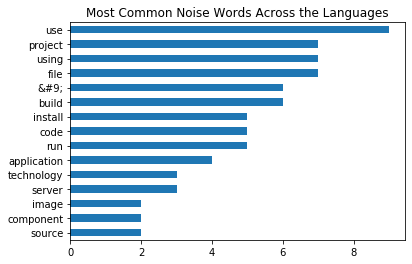

In [21]:
# Plot the words that appear in the most repos to find noise that can be removed.

top_20_words.languages_with_word.sort_values(ascending=False).head(15).plot(kind='barh')
plt.gca().invert_yaxis()

plt.title('Most Common Noise Words Across the Languages')
plt.show()

In [22]:
top_20_words.sort_values('languages_with_word', ascending=False).index[:10].tolist()

['use',
 'project',
 'using',
 'file',
 '&#9;',
 'build',
 'install',
 'code',
 'run',
 'application']

In [23]:
extra_words=['use','project','using','file','&#9;','build','install','run','application','code']

In [24]:
df = remove_stopwords(df, 'clean_lemmatized', extra_words = extra_words)

In [25]:
df.head()

,repo,language,readme_contents,clean_lemmatized,clean_clean_lemmatized
0,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movie application project building single page...,movie building single page movie spa allow use...
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel several guide kernel developer us...,linux kernel several guide kernel developer us...
2,nwjs/nw.js,JavaScript,## node-webkit is renamed NW.js\n\n[![Gitter](...,nodewebkit renamed nwjs gitterhttpsbadgesgitte...,nodewebkit renamed nwjs gitterhttpsbadgesgitte...
3,PKUanonym/REKCARC-TSC-UHT,HTML,# 清华大学计算机系课程攻略\n\n[![](https://img.shields.io/...,httpsimgshieldsiogithubwatcherspkuanonymrekcar...,httpsimgshieldsiogithubwatcherspkuanonymrekcar...
4,yeasy/docker_practice,Go,# Docker — 从入门到实践\n\n[![](https://img.shields....,docker httpsimgshieldsiogithubstarsyeasydocker...,docker httpsimgshieldsiogithubstarsyeasydocker...


In [26]:
# Create a dictionary to hold subsets by language.

lang_dict2 = {}

for lang in df.language:
    lang_dict2[f'{lang}'] = df[df.language == lang]

In [27]:
# Create strings of cleaned and lemmatized words by language.

js_words = ' '.join(lang_dict2['JavaScript'].clean_clean_lemmatized)
c_words = ' '.join(lang_dict2['C'].clean_clean_lemmatized)
html_words = ' '.join(lang_dict2['HTML'].clean_clean_lemmatized)
go_words = ' '.join(lang_dict2['Go'].clean_clean_lemmatized)
typescript_words = ' '.join(lang_dict2['TypeScript'].clean_clean_lemmatized)
c_plus_words = ' '.join(lang_dict2['C++'].clean_clean_lemmatized)
c_sharp_words = ' '.join(lang_dict2['C#'].clean_clean_lemmatized)
python_words = ' '.join(lang_dict2['Python'].clean_clean_lemmatized)
java_words = ' '.join(lang_dict2['Java'].clean_clean_lemmatized)

In [28]:
# Create df of top 20 words in each language subset
top_20_words2 = pd.concat([pd.Series(js_words.split()).value_counts().head(20), pd.Series(html_words.split()).value_counts().head(20)], axis=1)

# Rename columns in initial df.
top_20_words2.columns = ['js_words', 'html_words']

# Add columns of top 20 words for each language.
top_20_words2['python_words'] = pd.Series(python_words.split()).value_counts().head(20)
top_20_words2['java'] = pd.Series(java_words.split()).value_counts().head(20)
top_20_words2['c_words'] = pd.Series(c_words.split()).value_counts().head(20)
top_20_words2['c_plus_words'] = pd.Series(c_plus_words.split()).value_counts().head(20)
top_20_words2['c_sharp_words'] = pd.Series(c_sharp_words.split()).value_counts().head(20)
top_20_words2['go_words'] = pd.Series(go_words.split()).value_counts().head(20)
top_20_words2['typescript_words'] = pd.Series(typescript_words.split()).value_counts().head(20)

In [29]:
# Create a column that counts the number of repos a word appears in.

top_20_words2['languages_with_word'] = top_20_words2.loc[:,'js_words':'typescript_words'].notnull().sum(axis=1)

top_20_words2.sort_values('languages_with_word', ascending=False).head(10)

,js_words,html_words,python_words,java,c_words,c_plus_words,c_sharp_words,go_words,typescript_words,languages_with_word
1,131.0,NaN,65.0,NaN,30.0,102.0,NaN,25.0,NaN,5
data,120.0,NaN,122.0,NaN,NaN,NaN,36.0,14.0,NaN,4
make,112.0,NaN,NaN,NaN,60.0,NaN,NaN,16.0,NaN,3
version,NaN,50.0,NaN,85.0,34.0,NaN,NaN,NaN,NaN,3
server,162.0,NaN,NaN,77.0,NaN,NaN,NaN,NaN,30.0,3
technology,142.0,63.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,3
support,124.0,NaN,NaN,81.0,32.0,NaN,NaN,NaN,NaN,3
docker,NaN,43.0,NaN,NaN,NaN,NaN,NaN,24.0,NaN,2
image,NaN,74.0,NaN,NaN,NaN,NaN,57.0,NaN,NaN,2
html,116.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


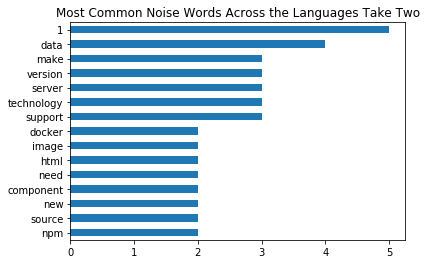

In [30]:
# Plot the words that appear in the most repos to find noise that can be removed.

top_20_words2.languages_with_word.sort_values(ascending=False).head(15).plot(kind='barh')
plt.gca().invert_yaxis()

plt.title('Most Common Noise Words Across the Languages Take Two')
plt.show()

In [31]:
# Remove a few more words that appear to be noise and move on.

extra_words = ['1', 'data', 'make', 'version', 'server', 'technology', 'support']
df = remove_stopwords(df, 'clean_lemmatized', extra_words = extra_words)

## Modeling

In [33]:
# Split my data

train, validate, test = split(df, 'language')
train.head()

,repo,language,readme_contents,clean_lemmatized,clean_clean_lemmatized
205,googlevr/seurat-unity-plugin,C#,# Importing Seurat Meshes Into Unity\n\nSeurat...,importing seurat mesh unity seurat scene simpl...,importing seurat mesh unity seurat scene simpl...
128,shuaishaui/springboot-technology,Java,# springboot-technology\nspringboot整合自己到目前学习到的...,springboottechnology springboot,springboottechnology springboot
208,kalaspuff/tomodachi,Python,``tomodachi`` - a lightweight microservices li...,tomodachi lightweight microservices library py...,tomodachi lightweight microservices library py...
75,dolevf/Damn-Vulnerable-GraphQL-Application,JavaScript,# Damn Vulnerable GraphQL Application\nDamn Vu...,damn vulnerable graphql application damn vulne...,damn vulnerable graphql application damn vulne...
214,tyrchen/book_next,JavaScript,---\ntitle: '程序君的公众号'\nauthor:\n - 程序君\nkeywo...,title author keywords readme,title author keywords readme


In [35]:
# Visualize my split data

print(train.shape, validate.shape, test.shape)

(148, 5) (64, 5) (54, 5)


In [39]:
# Setup our X variables

X_train = train.clean_clean_lemmatized
X_validate = validate.clean_clean_lemmatized
X_test = test.clean_clean_lemmatized

In [40]:
# Setup our y variables

y_train = train.language
y_validate = validate.language
y_test = test.language

In [43]:
# Create the tfidf vectorizer object
# Step 1, this creates a tf-idf values for each word, for each document
# Step 2, encodes these values so that we can use models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

### Create my baseline accuracy

In [60]:
# My baseline accuracy is 31% because JavaScript, the mode value, represents 31% of the language values in the df.

((df.language.value_counts().head(1).values / df.shape[0])[0])

0.3082706766917293

### 1. Logistic Regression Model

In [61]:
# Now that we have a vectorized dataset, we can use our classification tools!
lm = LogisticRegression()

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
train_eval = pd.DataFrame(dict(actual=y_train))
validate_eval = pd.DataFrame(dict(actual=y_validate))
test_eval = pd.DataFrame(dict(actual=y_test))

In [72]:
train_eval.head()

,actual
205,C#
128,Java
208,Python
75,JavaScript
214,JavaScript


In [73]:
# Use the trained model to predict y given those vectorized inputs of X

train_eval['predicted'] = lm.predict(X_train_vectorized)
validate_eval["predicted"] = lm.predict(X_validate_vectorized)
test_eval['predicted'] = lm.predict(X_test_vectorized)

In [74]:
train_eval.head()

,actual,predicted
205,C#,JavaScript
128,Java,Java
208,Python,JavaScript
75,JavaScript,JavaScript
214,JavaScript,JavaScript


In [77]:
# Train Accuracy

(train_eval.actual == train_eval.predicted).mean()

0.4391891891891892

In [76]:
# Out of sample accuracy

(validate_eval.actual == validate_eval.predicted).mean()

0.296875

In [78]:
# Classification report

from sklearn.metrics import classification_report
print(classification_report(train_eval.actual, train_eval.predicted))

              precision    recall  f1-score   support

           C       1.00      0.08      0.14        13
          C#       0.00      0.00      0.00        10
         C++       1.00      0.07      0.12        15
          Go       0.00      0.00      0.00         6
        HTML       1.00      0.07      0.12        15
        Java       1.00      0.75      0.86        20
  JavaScript       0.36      1.00      0.53        46
      Python       1.00      0.07      0.12        15
  TypeScript       0.00      0.00      0.00         8

    accuracy                           0.44       148
   macro avg       0.60      0.23      0.21       148
weighted avg       0.64      0.44      0.33       148



### 2. Decision Tree

In [79]:
# modeling and evaluating
from sklearn.tree import DecisionTreeClassifier

# Create the model

clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model

clf.fit(X_train_vectorized, y_train)

#### Train

In [79]:
# Use the model to get accuracy score for train dataset

clf.score(X_train_vectorized, y_train)

print(f'Accuracy of Decision Tree classifier on training set: {round(clf.score(X_train_vectorized, y_train) * 100)}%')

Accuracy of Decision Tree classifier on training set: 43%


#### Validate

In [81]:
# Use the model to get accuracy score for train dataset

clf.score(X_validate_vectorized, y_validate)

print(f'Accuracy of Decision Tree classifier on training set: {round(clf.score(X_validate_vectorized, y_validate) * 100)}%')

Accuracy of Decision Tree classifier on training set: 38%


In [82]:
# Create df to dig into accuracy by language.

dt_train_eval = pd.DataFrame(dict(actual=y_train))
dt_validate_eval = pd.DataFrame(dict(actual=y_validate))
dt_test_eval = pd.DataFrame(dict(actual=y_test))

In [83]:
# Use the trained dt model to predict y given those vectorized inputs of X.

dt_train_eval['predicted'] = clf.predict(X_train_vectorized)
dt_validate_eval["predicted"] =clf.predict(X_validate_vectorized)
dt_test_eval['predicted'] = clf.predict(X_test_vectorized)

In [97]:
df.language.value_counts()

JavaScript    82
Java          36
Python        28
C++           28
HTML          27
C             23
C#            17
TypeScript    14
Go            11
Name: language, dtype: int64

##### Dig into JavaScript Accuracy

In [88]:
js_dt_eval = dt_train_eval[dt_train_eval.actual == 'JavaScript']

In [90]:
(js_dt_eval.actual == js_dt_eval.predicted).mean()

1.0

##### Dig into Python Accuracy

In [92]:
python_dt_eval = dt_train_eval[dt_train_eval.actual == 'Python']

In [93]:
(python_dt_eval.actual == python_dt_eval.predicted).mean()

0.4

##### Dig into Java Accuracy

In [94]:
j_dt_eval = dt_train_eval[dt_train_eval.actual == 'Java']

In [95]:
(j_dt_eval.actual == j_dt_eval.predicted).mean()

0.45

##### Dig into Go Accuracy

In [98]:
g_dt_eval = dt_train_eval[dt_train_eval.actual == 'Go']
(g_dt_eval.actual == g_dt_eval.predicted).mean()

0.0

### Let's Try Balancing the Dataset

- 